# Assignment 7 - RNN

## Submission by: Mark Preston

This week, I'll be using recursive neural networks (RNN) to detect security breaches by predicting suspicious access using an Logfile data. This Logfile data includes login information like LogID, Timestamp, Method, Path, Status Code, Source, Remote Address, User Agent, among other variables. The last indicator in each row denotes whether a break took place, which is the binary target variable.

### Data Processing

Below, I've gone through the data loading and processing steps. As seen, the initial log file data only has two columns. However, the first column has json data structures in each row so the set has more to unpack.

In [1]:
import sys
import os
import json
import pandas
import numpy
import optparse

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

C:\Users\Mark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import pandas as pd

dev_security = pd.read_csv("dev-access.csv", engine='python', quotechar='|', header=None)

print("Dev security data set has", 
      dev_security.shape[0], "rows and", 
      dev_security.shape[1],  "columns")

dev_security.head()

Dev security data set has 26773 rows and 2 columns


,0,1
0,"{""timestamp"":1502738402847,""method"":""post"",""qu...",0
1,"{""timestamp"":1502738402849,""method"":""post"",""qu...",0
2,"{""timestamp"":1502738402852,""method"":""post"",""qu...",0
3,"{""timestamp"":1502738402852,""method"":""post"",""qu...",0
4,"{""timestamp"":1502738402853,""method"":""post"",""qu...",0


In [22]:
class_balance = dev_security[1].value_counts()

print("Total non-breaches:", class_balance[0])
print("Non-breaches proportion:", round(class_balance[0] / dev_security.shape[0], 4) * 100)
print("Total breaches:", class_balance[1])
print("Breaches proportion:", round(class_balance[1] / dev_security.shape[0], 4) * 100)

Total non-breaches: 13413
Non-breaches proportion: 50.1
Total breaches: 13360
Breaches proportion: 49.9


In this section, I'm converting the initial data frame into a numpy array, which will be used in the modelling work. The first column, or 0th index, comprises the predictors, which are further split below given many are text based. The other column is a zero or one indicating a breach.

In [3]:
import numpy as np

np_dev_security = dev_security.values

predictors = np_dev_security[:,0]

outcome = np_dev_security[:,1]

In [4]:
for index, item in enumerate(predictors):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    predictors[index] = json.dumps(reqJson, separators=(',', ':'))

I mentioned this above but, the predictors contain text entries, which tokenized and indexed below. The final object, X_processed, is carried forward for train and test development, which is done using 75/25 proportions. As seen, there are 1024 columns, each of which represents a variable from the json data.

In [5]:
tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(predictors)

num_words = len(tokenizer.word_index) + 1
predictors = tokenizer.texts_to_sequences(predictors)

max_log_length = 1024
X_processed = sequence.pad_sequences(predictors, maxlen=max_log_length)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_processed, outcome, random_state=1017, test_size=.25)

print(
"Training set rows:", X_train.shape[0], "which is", 
    np.round(X_train.shape[0] / dev_security.shape[0] * 100), 
    "percent of total records"
)

print(
"Training set columns:", X_train.shape[1]
)

print(
"Test set rows:", X_test.shape[0], "which is", 
    np.round(X_test.shape[0] / dev_security.shape[0] * 100),
    "percent of total records"
)

print(
"Test set columns:", X_test.shape[1]
)

Training set rows: 20079 which is 75.0 percent of total records
Training set columns: 1024
Test set rows: 6694 which is 25.0 percent of total records
Test set columns: 1024


### Model 1 - RNN

The first model here is a basic RNN. I've included binary accuracy for the metric because using accuracy by itself forces Keras to pick a default. Despite being a more simple neural network, the model still had 4,129 parameters, a number that is far higher than any traditional statistical or machine learning method.

In [77]:
from keras.layers import SimpleRNN

model_one = Sequential()
model_one.add(Embedding(input_dim = num_words, 
                        output_dim = 32, 
                        input_length = max_log_length)
         )
model_one.add(SimpleRNN(units=32, activation="relu"))
model_one.add(Dense(activation="sigmoid", units=1))

model_one.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["binary_accuracy"])

model_one.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 1024, 32)          2016      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 33        
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


The benefit of using a more simplistic architecture is speed. The model trains in a relatively short time with each epoch taking under a minute to complete. The validation accuracy at epch two reached about 91% but, fell back into the 60s after this. The validation history plot for both accuracy and binary cross entropy show large kinks that highlight this effect. This likely would even out with more epochs to a higher accuracy but, in this instance, the validation accuracy shows some variance. Using the model evaluation though, the binary accuracy still shows 95.8%. Despite being the baseline model here, the simple RNN provides a good result.

In [78]:
model_one_hist = model_one.fit(x= X_train, 
                               y= y_train, 
                               batch_size = 128, 
                               epochs = 3, 
                               validation_split = .25)

Train on 15059 samples, validate on 5020 samples
Epoch 1/3
15059/15059 [==============================] - 41s 3ms/step - loss: 0.6039 - binary_accuracy: 0.6967 - val_loss: 0.6576 - val_binary_accuracy: 0.6841
Epoch 2/3
15059/15059 [==============================] - 36s 2ms/step - loss: 0.5190 - binary_accuracy: 0.7464 - val_loss: 0.3992 - val_binary_accuracy: 0.9064
Epoch 3/3
15059/15059 [==============================] - 37s 2ms/step - loss: 0.5671 - binary_accuracy: 0.6952 - val_loss: 0.5782 - val_binary_accuracy: 0.6526


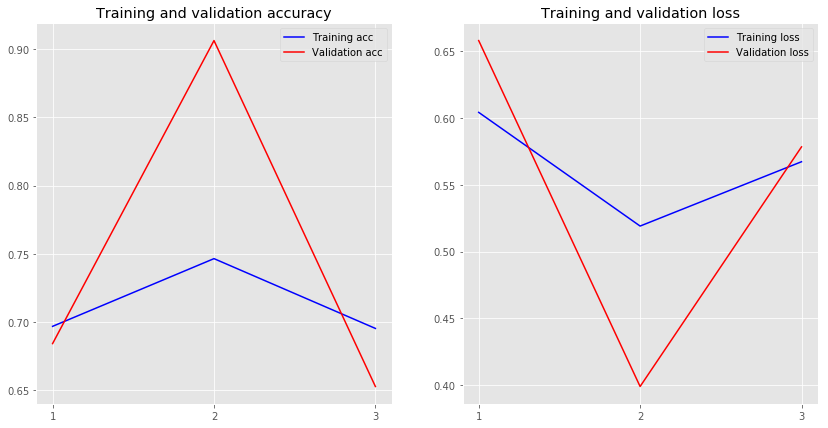

In [79]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")  

def plot_history(history):
    acc = history.history["binary_accuracy"]
    val_acc = history.history["val_binary_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training acc")
    plt.plot(x, val_acc, "r", label="Validation acc")
    plt.xticks(x, x)
    plt.title("Training and validation accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.xticks(x, x)
    plt.title("Training and validation loss")
    plt.legend()
    
plot_history(history=model_one_hist)

In [12]:
model1_eval_metrics = model_one.evaluate(x = X_test, 
                                         y = y_test, 
                                         batch_size = 128)

print("Loss value:", model1_eval_metrics[0].round(4))
print("Model Accuracy:", model1_eval_metrics[1].round(4))

6694/6694 [==============================] - 10s 2ms/step
Loss value: 0.151
Model Accuracy: 0.958


### Model 2 - RNN + Dropout Layers + New Activation Function

for the second model, I've added some further complexity. The major addition here is a Long-Short Term Memory (LSTM) layer. An LSTM is a type of RNN with an added "memory cell" that maintains memory over the model. In practice, this memory is managed using gates that control aspects of memory storage. This includes when it reaches output and when it's forgotten. One noticeable effect here is the the explosion of parameters to almost 27,000. Additionally, drop out has been added. This drops certain units in the network, which can help prevent overfitting.

In [74]:
from keras.layers import LSTM
from keras.layers import Dropout

model_two = Sequential()
model_two.add(Embedding(input_dim = num_words, 
                        output_dim = 32, 
                        input_length = max_log_length)
         )
model_two.add(LSTM(units=64, recurrent_dropout = 0.5))
model_two.add(Dropout(rate = .5))
model_two.add(Dense(activation="sigmoid", units=1))

model_two.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["binary_accuracy"])

model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 1024, 32)          2016      
_________________________________________________________________
lstm_42 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


The second more complex model performs much better when compared to the baseline. The cross entropy drops to .25 while the binary accuracy decreases slightly to about 94.68%.

In [75]:
model_two_hist = model_two.fit(x = X_train, 
                               y = y_train, 
                               batch_size = 128, 
                               epochs = 3, 
                               validation_split = .25)

Train on 15059 samples, validate on 5020 samples
Epoch 1/3
15059/15059 [==============================] - 370s 25ms/step - loss: 0.5909 - binary_accuracy: 0.6784 - val_loss: 0.4102 - val_binary_accuracy: 0.8157
Epoch 2/3
15059/15059 [==============================] - 345s 23ms/step - loss: 0.3586 - binary_accuracy: 0.8756 - val_loss: 0.2416 - val_binary_accuracy: 0.9416
Epoch 3/3
15059/15059 [==============================] - 349s 23ms/step - loss: 0.2517 - binary_accuracy: 0.9291 - val_loss: 0.1934 - val_binary_accuracy: 0.9514


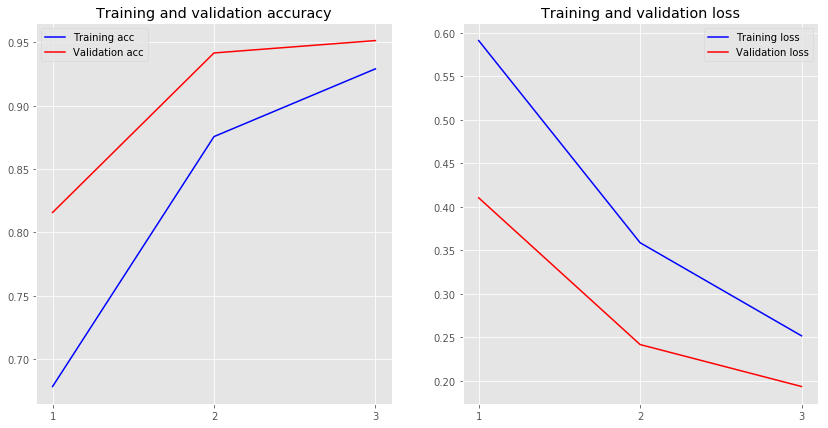

In [80]:
plot_history(history = model_two_hist)

In [81]:
model2_eval_metrics = model_two.evaluate(x = X_test, 
                                         y = y_test, 
                                         batch_size = 128)

print("Loss value:", model2_eval_metrics[0].round(4))
print("Model Accuracy:", model2_eval_metrics[1].round(4))

6694/6694 [==============================] - 39s 6ms/step
Loss value: 0.2091
Model Accuracy: 0.9468


### Build your own RNN

For the final RNN, I've developed a deep learning model with the addition of a second LSTM. This again pushes the parameter totals higher, this time including around 35,000. Playing around with the set up, I've also included batch normalization and further drop out to help with possible overfitting while also switching the optimizer to nadam (Nesterov Adam, which is Adam but with RMSprop and Nesterov momentum). 

In [86]:
from keras.layers import BatchNormalization

model_three = Sequential()
model_three.add(Embedding(input_dim = num_words, 
                        output_dim = 32, 
                        input_length = max_log_length)
         )
model_three.add(LSTM(units=32, return_sequences=True, recurrent_dropout = 0.5))
model_three.add(BatchNormalization())
model_three.add(Dropout(rate = .5))
model_three.add(LSTM(units=64, recurrent_dropout = .5))
model_three.add(BatchNormalization())
model_three.add(Dropout(rate = .5))
model_three.add(Dense(activation="sigmoid", units=1))

model_three.compile(loss = "binary_crossentropy", optimizer = "nadam", metrics = ["binary_accuracy"])

model_three.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 1024, 32)          2016      
_________________________________________________________________
lstm_45 (LSTM)               (None, 1024, 32)          8320      
_________________________________________________________________
batch_normalization_22 (Batc (None, 1024, 32)          128       
_________________________________________________________________
dropout_42 (Dropout)         (None, 1024, 32)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 64)                24832     
_________________________________________________________________
batch_normalization_23 (Batc (None, 64)                256       
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
__________

The results here are another improvement with the final validation accuracy at about 99.45%. The deep learning model here provides almost perfect prediction for the network breaches. As such, this is the preferred model here.

In [87]:
model_three_hist = model_three.fit(x = X_train, 
                                   y = y_train, 
                                   batch_size = 128, 
                                   epochs = 3, 
                                   validation_split = .25)

Train on 15059 samples, validate on 5020 samples
Epoch 1/3
15059/15059 [==============================] - 483s 32ms/step - loss: 0.6084 - binary_accuracy: 0.6697 - val_loss: 0.2790 - val_binary_accuracy: 0.9010
Epoch 2/3
15059/15059 [==============================] - 489s 32ms/step - loss: 0.2168 - binary_accuracy: 0.9134 - val_loss: 0.0642 - val_binary_accuracy: 0.9693
Epoch 3/3
15059/15059 [==============================] - 465s 31ms/step - loss: 0.0431 - binary_accuracy: 0.9876 - val_loss: 0.0140 - val_binary_accuracy: 0.9962


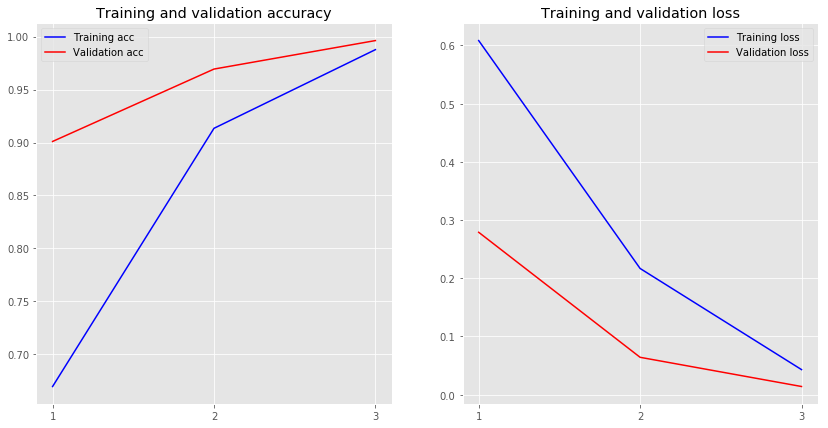

In [88]:
plot_history(history = model_three_hist)

In [89]:
model3_eval_metrics = model_three.evaluate(x = X_test, 
                                           y = y_test, 
                                           batch_size = 128)

print("Loss value:", model3_eval_metrics[0].round(4))
print("Model Accuracy:", model3_eval_metrics[1].round(4))

6694/6694 [==============================] - 78s 12ms/step
Loss value: 0.0194
Model Accuracy: 0.9945


### Conceptual Questions

#### Explain the difference between the relu activation function and the sigmoid activation function.

From a conceptual level, the sigmoid and relu (Rectified Linear Unit) functions have different shapes. The familiar sigmoid, used in logistic regression, is a curvy S shape that exists between 0 and 1, while relu is a linear line which becomes flat when $x = 0$. The function is differentiable, which means a slope for the function can be found at any two points. In contrast, relu ranges form 0 to positive infinity. The function has values of zero when x is zero and, when x is less than zero. Above zero, the function matches the value of x. It is a monotonic function. Sigmoid tends to have an issue with vanishing gradients, something that relu helps curb. Overall, both functions have different shapes and underlying mathematical properties. Relu is generally recognized as the most common activation function as well.

#### Describe what one epoch actually is (epoch was a parameter used in the .fit() method).

Epochs in the keras fit defines how many times the model goes through the entire training set. Each time, the model is being updated. In this sense, the model is updated iteratively throughout the epoch but, also between different epochs. This can be seen in the included models, especially in the loss visualization graphs. The loss value declines from epoch 1 to 3 highlighting the model is being updated using the set across these three runs. Additionally, since batch size is set to 128, this governs when the model is updated. In these examples, this means the model is updated periodically every 128 records; when the batch length is equal to the length of the training set, the model is only updated once an epoch.

#### Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.

Droput is a regularization technique used to reduce overfitting in deep learning and neural networks more broadly. This layer specifies the probability of certain inputs moving to zero. In the models I developed, the rates were set to .5 and .3 indicating that in the layers, different subsets using the same parameters had those levels of probability of being dropped. As a rule of thumb, drop out is added between other layers, which is then applied to outputs of the prior layer that are fed to the subsequent layer. Droput works during model training so it doesn't explicitly affect the test set, save for helping to reduce overfitting.

#### Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?

This analysis focuses on detecting security breaches using log files. Inherently, these log files have some explicit ordering and sequence. For example, there's a time stamp that starts the event followed by details of it. Given this, there's a need for a modelling solution that accounts for the time element, which RNNs do. With this in mind, time and sequence dependent analyses are better addressed using am RNN. This might include forecasting, text generation, language translation, or anything where ordering and historical context are essential to the problem. In contrast, CNNs (Convolutional Neural Networks) are better suited for computer vision tasks, including image and object detection. This is because the method there is a hierarchical architecture that enables feature detection across different layers.

#### Explain what RNN problem is solved using LSTM and briefly describe how.

LSTMs are a class of RNN and both are generally used on problems involving time, ordering, and sequence. RNNs have feedback loops in recurrent layers; these enable some short term memory or ordering but, not long-term memory. This stems from exponential gradient decay over training (gradient loss or decay). LSTM solves this as it includes memory cells that help maintain long term memory for sequences. These are controlled using gates that governs when certain model portions enter long term memory and when they are forgotten. The architecture equips longer term dependencies making the model type ideal for applications where this is needed (like forecasting).

In [62]:
import os

os.getcwd()

'C:\\Users\\Mark\\Machine Learning 7'